In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime, timedelta

import xgboost as xgb

%matplotlib inline

In [2]:
train = pd.read_csv("Data/train.csv") 
test = pd.read_csv("Data/test.csv")

In [3]:
train["TRDATETIME"] = pd.to_datetime(train.TRDATETIME, format='%d%b%y:%H:%M:%S')
test["TRDATETIME"] = pd.to_datetime(test.TRDATETIME, format='%d%b%y:%H:%M:%S')

In [4]:
train["log_target_sum"] = np.log(train.target_sum + 1)

In [5]:
k = train["cl_id"].unique()
v = train.groupby("cl_id")["target_flag"].value_counts().values
d = {k[i] : v[i] for i in range(k.shape[0])}
train["use_count"] = np.log(train["cl_id"].apply(lambda x: d[x])+1)

In [6]:
target_flag = train.groupby("cl_id")["target_flag"].first()
target_sum = train.groupby("cl_id")["log_target_sum"].first()

In [7]:
use_time = train[["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1)

In [8]:
days = use_time.apply(lambda x: x.days)

In [9]:
pd.concat((days, train.target_flag, train.log_target_sum), axis=1).corr()

,0,target_flag,log_target_sum
0,1.000000,-0.050064,-0.042936
target_flag,-0.050064,1.000000,0.949304
log_target_sum,-0.042936,0.949304,1.000000


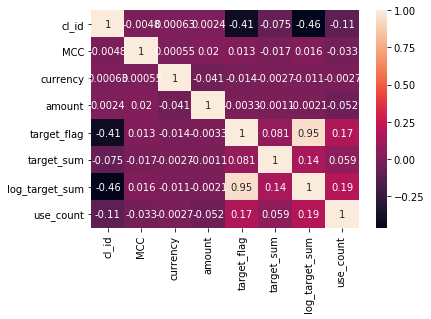

In [10]:
sns.heatmap(train.corr(), annot=True)

In [11]:
train.groupby("cl_id")["TRDATETIME"].agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1).head()

cl_id
0    53 days 11:35:53
1    92 days 00:00:00
5    92 days 00:00:00
9    89 days 15:51:03
10   89 days 05:14:47
dtype: timedelta64[ns]

In [12]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,log_target_sum,use_count
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,0.0,1.791759
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,0.0,1.791759
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,0.0,0.0,1.791759
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,0.0,1.791759
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,0.0,1.791759


In [53]:
x[1:].append([x[:1]+timedelta(weeks=4*3)])

0   2017-10-21 00:00:00
3   2017-10-21 00:00:00
4   2017-10-24 13:14:24
2   2017-12-05 00:00:00
1   2018-01-04 12:24:07
Name: TRDATETIME, dtype: datetime64[ns]

In [71]:
x[1:].append([x[:1]+timedelta(weeks=4*3)]).reset_index(drop=True) - x.reset_index(drop=True)

0    8 days 11:35:53
1    0 days 00:00:00
2    3 days 13:14:24
3   41 days 10:45:36
4   30 days 12:24:07
Name: TRDATETIME, dtype: timedelta64[ns]

In [54]:
delta_use = train[train.trx_category == "POS"].sort_values("TRDATETIME").groupby('cl_id')["TRDATETIME"].apply(lambda x: x[1:].append([x[:1]+timedelta(weeks=4*3)]).reset_index(drop=True) - x.reset_index(drop=True))
# delta_use = delta_use.apply(lambda x: x.days if x.days >=0 else 0)

In [55]:
max_use = delta_use.apply(lambda x: x.days if x.days >=0 else 0).groupby("cl_id").agg("mean")

In [133]:
pd.concat((use_time.apply(lambda x: x.days), np.log(max_use+1), target_flag, target_sum), axis=1).corr()

,0,TRDATETIME,target_flag,log_target_sum
0,1.000000,-0.291241,0.269978,0.271190
TRDATETIME,-0.291241,1.000000,-0.289257,-0.317469
target_flag,0.269978,-0.289257,1.000000,0.954838
log_target_sum,0.271190,-0.317469,0.954838,1.000000


In [8]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,log_target_sum,use_count
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,0.0,5
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,0.0,5
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,0.0,0.0,5
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,0.0,5
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,0.0,5


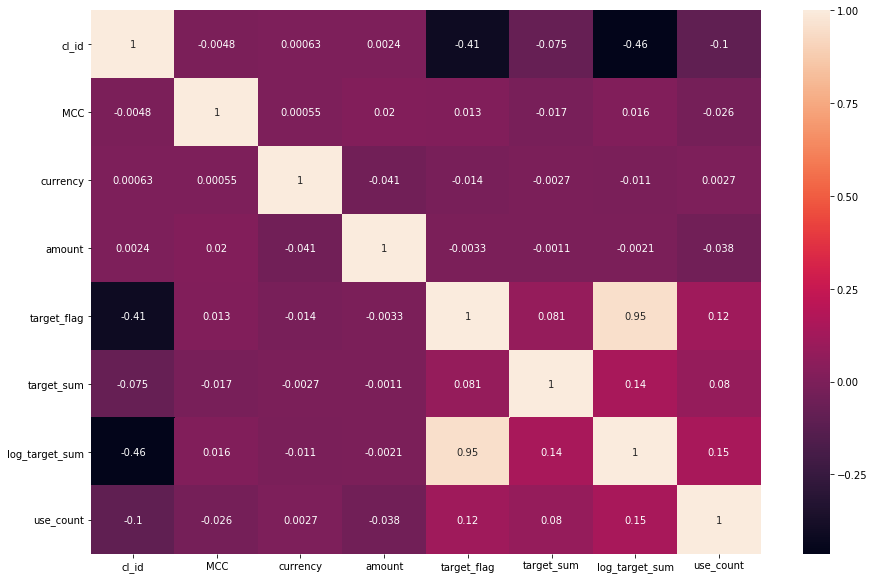

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), annot=True)

In [14]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,log_target_sum,use_count
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,0.0,5
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,0.0,5
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,0.0,0.0,5
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,0.0,5
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,0.0,5


In [14]:
channel_type_sign = {
    "type1" : 1,
    "type2" : 1,
    "type3" : 1,
    "type4" : -1,
    "type5" : -1
}

In [36]:
train = train.drop("sign_cl_id", axis=1)

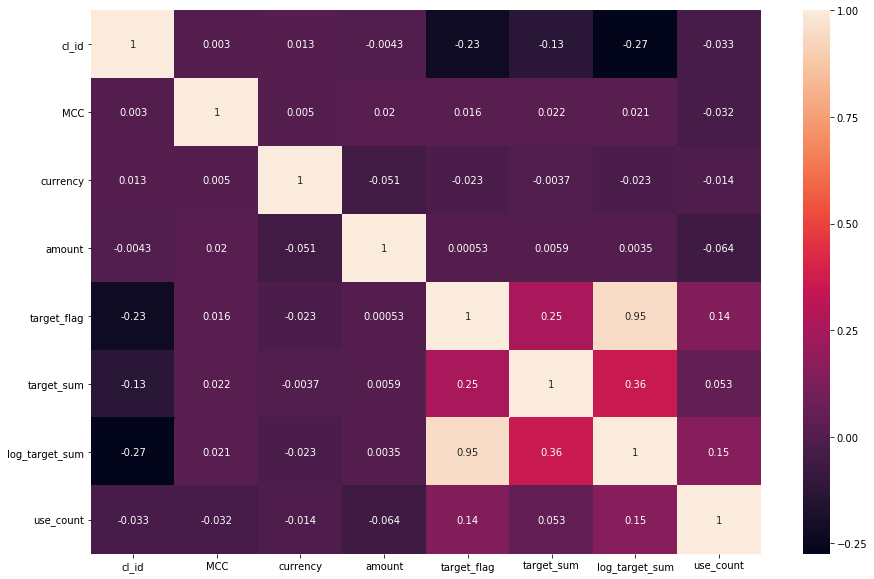

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(train[train.channel_type == "type1"].corr(), annot=True)

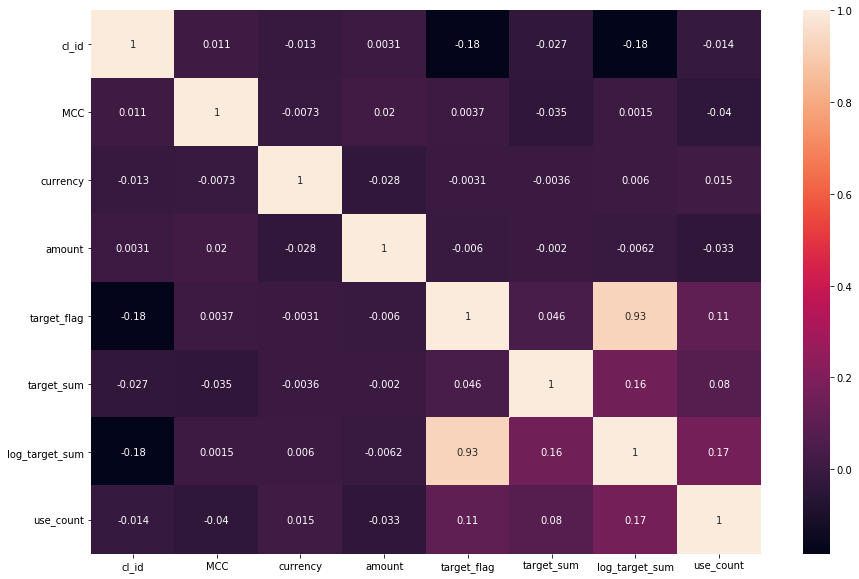

In [41]:
plt.figure(figsize=(15, 10))
sns.heatmap(train[train.channel_type == "type2"].corr(), annot=True)

In [11]:
convTrain = train.groupby("cl_id")[["channel_type", "target_flag", "use_count", "log_target_sum"]].first().reset_index()

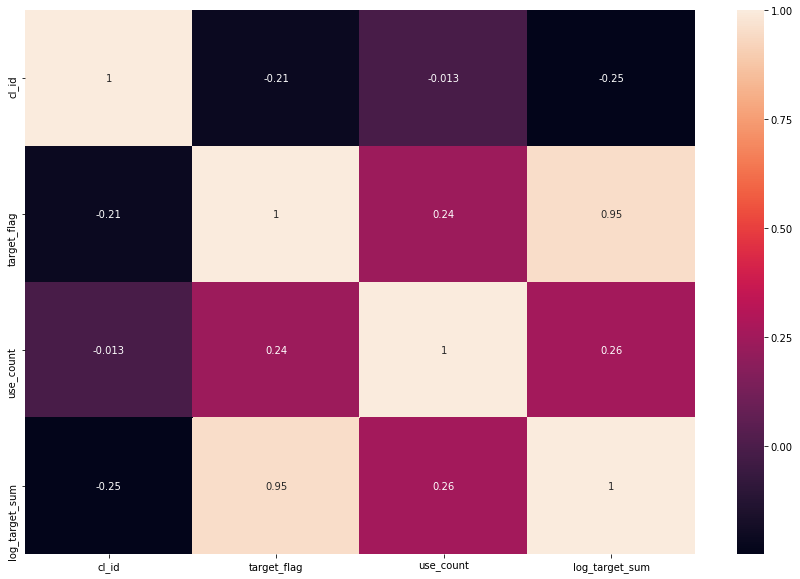

In [43]:
plt.figure(figsize=(15, 10))
sns.heatmap(convTrain[convTrain.channel_type == "type1"].corr(), annot=True)

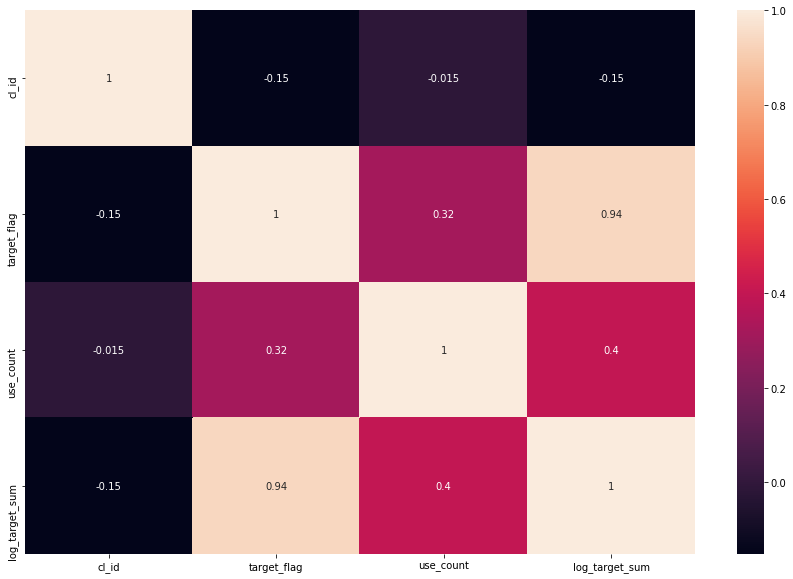

In [44]:
plt.figure(figsize=(15, 10))
sns.heatmap(convTrain[convTrain.channel_type == "type2"].corr(), annot=True)

In [16]:
m = {name: i+1 for i, name in enumerate(train.channel_type.unique())}

In [17]:
convTrain.channel_type = convTrain.channel_type.map(m)

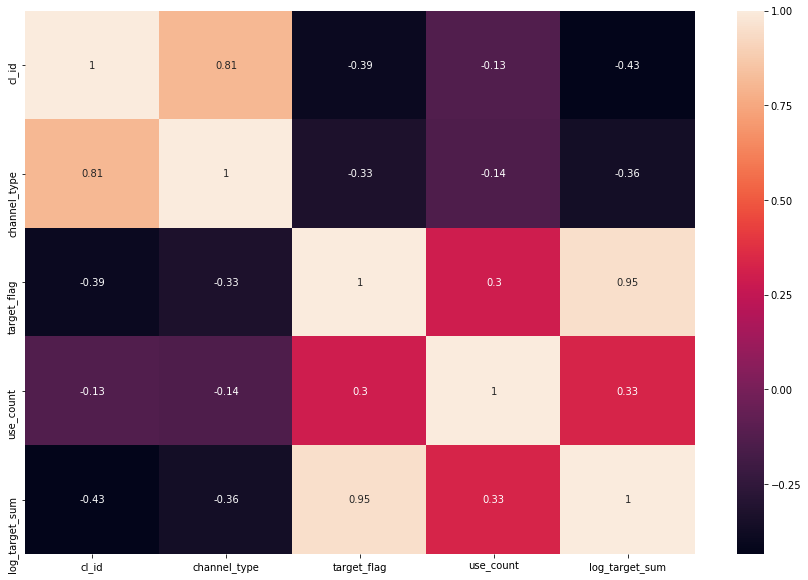

In [21]:
plt.figure(figsize=(15, 10))
sns.heatmap(convTrain.corr(), annot=True)

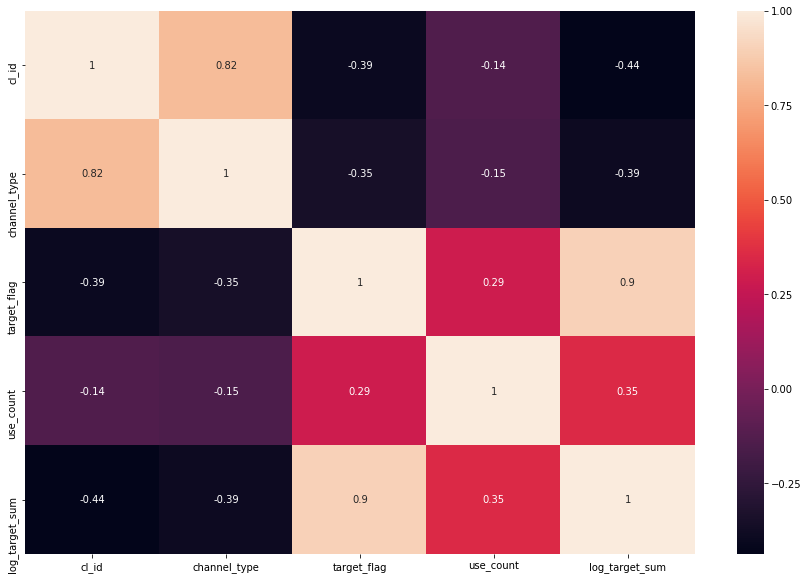

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(convTrain.corr(method="spearman"), annot=True)

In [30]:
train["month"] = train.TRDATETIME.apply(lambda x: x.month)

In [42]:
mcc_group = train.groupby("cl_id")["MCC"].value_counts().unstack().fillna(0).reset_index(drop=True)

In [46]:
cor = pd.concat((mcc_group, convTrain.target_flag), axis=1).corr()

In [52]:
new_train = pd.read_pickle("new_train")

In [53]:
new_train.corr()

cl_id    amount                      \
trx_category                             BACK_TRX    C2C_IN   C2C_OUT   
               trx_category                                             
cl_id                          1.000000  0.027613 -0.023750 -0.070700   
amount         BACK_TRX        0.027613  1.000000  0.157581  0.111101   
               C2C_IN         -0.023750  0.157581  1.000000  0.188676   
               C2C_OUT        -0.070700  0.111101  0.188676  1.000000   
               CASH_ADV       -0.017480 -0.003308  0.037048 -0.004214   
               CAT            -0.043657 -0.002837 -0.014505  0.023749   
               DEPOSIT         0.102513  0.000497 -0.026024  0.034397   
               POS            -0.026416  0.352950  0.013519  0.006911   
               WD_ATM_OTHER   -0.012714  0.649655  0.002844 -0.000713   
               WD_ATM_PARTNER  0.013845  0.153782  0.017148  0.038371   
               WD_ATM_ROS     -0.053066  0.027373 -0.017546  0.069011   
target_flag                   -0.392689  0.000354  0.005552  0.047046   
log_target_sum                -0.433875  0.007818  0.011748  0.049442   
target_sum                    -0.065459  0.008234 -0.001537  0.008325   
useDay                        -0.124290  0.010333  0.038278  0.049389   
missClass                      0.114210 -0.014024  0.028389 -0.012542   

                                                                       \
trx_category                   CASH_ADV       CAT   DEPOSIT       POS   
               trx_category                                             
cl_id                         -0.017480 -0.043657  0.102513 -0.026416   
amount         BACK_TRX       -0.003308 -0.002837  0.000497  0.352950   
               C2C_IN          0.037048 -0.014505 -0.026024  0.013519   
               C2C_OUT        -0.004214  0.023749  0.034397  0.006911   
               CASH_ADV        1.000000 -0.002274  0.000435 -0.000780   
               CAT            -0.002274  1.000000  0.023760 -0.001897   
               DEPOSIT         0.000435  0.023760  1.000000  0.025098   
               POS            -0.000780 -0.001897  0.025098  1.000000   
               WD_ATM_OTHER   -0.000561 -0.001293  0.000789  0.508536   
               WD_ATM_PARTNER -0.007809 -0.003254 -0.048232 -0.007532   
               WD_ATM_ROS     -0.006065  0.009925 -0.002176  0.011289   
target_flag                   -0.008057  0.028773  0.020623  0.057917   
log_target_sum                -0.005914  0.032048  0.018285  0.071792   
target_sum                    -0.001617  0.001715 -0.006349  0.015984   
useDay                        -0.002262  0.004793  0.141801  0.066831   
missClass                     -0.003321 -0.001382  0.024494 -0.022087   

                                                                      \
trx_category                  WD_ATM_OTHER WD_ATM_PARTNER WD_ATM_ROS   
               trx_category                                            
cl_id                            -0.012714       0.013845  -0.053066   
amount         BACK_TRX           0.649655       0.153782   0.027373   
               C2C_IN             0.002844       0.017148  -0.017546   
               C2C_OUT           -0.000713       0.038371   0.069011   
               CASH_ADV          -0.000561      -0.007809  -0.006065   
               CAT               -0.001293      -0.003254   0.009925   
               DEPOSIT            0.000789      -0.048232  -0.002176   
               POS                0.508536      -0.007532   0.011289   
               WD_ATM_OTHER       1.000000       0.005724   0.028988   
               WD_ATM_PARTNER     0.005724       1.000000   0.122775   
               WD_ATM_ROS         0.028988       0.122775   1.000000   
target_flag                       0.031801      -0.025433   0.032061   
log_target_sum                    0.035963      -0.014932   0.044636   
target_sum                        0.003736      -0.001580   0.007149   
useDay                            

In [65]:
max_use = delta_use.apply(lambda x: x.days if x.days >=0 else 0).groupby("cl_id").agg("sum")

In [66]:
pd.concat((max_use.reset_index(drop=True), new_train), axis=1).corr()

,TRDATETIME,"(cl_id, )","(amount, BACK_TRX)","(amount, C2C_IN)","(amount, C2C_OUT)","(amount, CASH_ADV)","(amount, CAT)","(amount, DEPOSIT)","(amount, POS)","(amount, WD_ATM_OTHER)","(amount, WD_ATM_PARTNER)","(amount, WD_ATM_ROS)","(target_flag, )","(log_target_sum, )","(target_sum, )","(useDay, )","(missClass, )"
TRDATETIME,1.000000,-0.184453,-0.010580,-0.007812,-0.006472,-0.008305,-0.011926,0.016588,0.051981,0.029468,-0.045731,-0.023849,0.298017,0.326583,0.052564,0.263556,-0.079277
"(cl_id, )",-0.184453,1.000000,0.027613,-0.023750,-0.070700,-0.017480,-0.043657,0.102513,-0.026416,-0.012714,0.013845,-0.053066,-0.392689,-0.433875,-0.065459,-0.124290,0.114210
"(amount, BACK_TRX)",-0.010580,0.027613,1.000000,0.157581,0.111101,-0.003308,-0.002837,0.000497,0.352950,0.649655,0.153782,0.027373,0.000354,0.007818,0.008234,0.010333,-0.014024
"(amount, C2C_IN)",-0.007812,-0.023750,0.157581,1.000000,0.188676,0.037048,-0.014505,-0.026024,0.013519,0.002844,0.017148,-0.017546,0.005552,0.011748,-0.001537,0.038278,0.028389
"(amount, C2C_OUT)",-0.006472,-0.070700,0.111101,0.188676,1.000000,-0.004214,0.023749,0.034397,0.006911,-0.000713,0.038371,0.069011,0.047046,0.049442,0.008325,0.049389,-0.012542
"(amount, CASH_ADV)",-0.008305,-0.017480,-0.003308,0.037048,-0.004214,1.000000,-0.002274,0.000435,-0.000780,-0.000561,-0.007809,-0.006065,-0.008057,-0.005914,-0.001617,-0.002262,-0.003321
"(amount, CAT)",-0.011926,-0.043657,-0.002837,-0.014505,0.023749,-0.002274,1.000000,0.023760,-0.001897,-0.001293,-0.003254,0.009925,0.028773,0.032048,0.001715,0.004793,-0.001382
"(amount, DEPOSIT)",0.016588,0.102513,0.000497,-0.026024,0.034397,0.000435,0.023760,1.000000,0.025098,0.000789,-0.048232,-0.002176,0.020623,0.018285,-0.006349,0.141801,0.024494
"(amount, POS)",0.051981,-0.026416,0.352950,0.013519,0.006911,-0.000780,-0.001897,0.025098,1.000000,0.508536,-0.007532,0.011289,0.057917,0.071792,0.015984,0.066831,-0.022087
"(amount, WD_ATM_OTHER)",0.029468,-0.012714,0.649655,0.002844,-0.000713,-0.000561,-0.001293,0.000789,0.508536,1.000000,0.005724,0.028988,0.031801,0.035963,0.003736,0.015807,-0.017592


In [67]:
mcc_group = train.groupby("cl_id")["MCC"].value_counts().unstack().fillna(0).reset_index(drop=True)

In [70]:
tmp = pd.concat((mcc_group[6011], new_train.missClass), axis=1).corr()["missClass"]

In [71]:
tmp.sort_values()

6011        -0.102587
4814        -0.058370
5814        -0.054580
5735        -0.034781
9311        -0.033234
5309        -0.033135
9399        -0.032171
5812        -0.031674
5611        -0.031293
7230        -0.029933
4900        -0.029688
5734        -0.026107
5948        -0.024763
7998        -0.024367
7392        -0.024083
5977        -0.022876
3533        -0.022825
3504        -0.022710
5655        -0.022631
5200        -0.022456
5085        -0.021884
5719        -0.021264
4112        -0.020840
3010        -0.020814
6538        -0.020604
7299        -0.020242
5999        -0.020167
7375        -0.020101
3381        -0.020024
7338        -0.019414
               ...   
6010         0.024828
3136         0.025826
5013         0.026317
3051         0.026447
5937         0.026447
3545         0.026447
3625         0.026447
7631         0.026447
3778         0.026447
3057         0.026447
3824         0.026447
3515         0.026447
3628         0.026447
3607         0.026447
3260      

In [79]:
train.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum', 'log_target_sum',
       'use_count'],
      dtype='object')

In [154]:
dummy = train.groupby(["cl_id", "currency"]).amount.agg("max").unstack().fillna(0).reset_index(drop=True)

In [120]:
tmp = pd.concat((dummy, new_train.missClass), axis=1)[(convTrain.channel_type != "type1") & (convTrain.channel_type != "type2")].corr()

In [155]:
tmp = pd.concat((dummy, new_train.missClass), axis=1)[(convTrain.channel_type == "type1")].corr()

In [156]:
tmp["missClass"].sort_values()

810         -0.068091
978         -0.027412
203         -0.019053
498         -0.016536
752         -0.016285
392         -0.016122
398         -0.016069
578         -0.015510
410         -0.015320
51          -0.015132
941         -0.014534
826         -0.014112
504         -0.013747
208         -0.013671
348         -0.012838
985         -0.012614
784         -0.012436
933         -0.012358
191         -0.011444
756         -0.010689
554         -0.010340
480         -0.010340
986         -0.010340
946         -0.010340
710         -0.010340
462         -0.010340
634         -0.010340
484         -0.010340
690         -0.010340
608         -0.010340
901         -0.010340
32          -0.010340
344         -0.010220
376         -0.010010
975         -0.009055
704         -0.008291
360         -0.006569
36          -0.006380
356         -0.001936
944         -0.000689
643         -0.000569
949          0.001330
458          0.004281
840          0.016168
214          0.018009
980       

In [194]:
new_train[convTrain.channel_type == "type5"].corr()

cl_id    amount                      \
trx_category                             BACK_TRX    C2C_IN   C2C_OUT   
               trx_category                                             
cl_id                          1.000000  0.295196  0.006160  0.003117   
amount         BACK_TRX        0.295196  1.000000 -0.110629 -0.090953   
               C2C_IN          0.006160 -0.110629  1.000000  0.267043   
               C2C_OUT         0.003117 -0.090953  0.267043  1.000000   
               CASH_ADV             NaN       NaN       NaN       NaN   
               CAT            -0.243807 -0.074751 -0.061797 -0.077662   
               DEPOSIT         0.262362 -0.069727  0.061940 -0.031367   
               POS            -0.113311  0.063237 -0.052096 -0.091104   
               WD_ATM_OTHER   -0.167016 -0.060881 -0.079757  0.742864   
               WD_ATM_PARTNER  0.045408  0.018008  0.219195  0.592942   
               WD_ATM_ROS     -0.142639 -0.010500 -0.118488  0.696335   
target_flag                    0.147551 -0.187580  0.173760  0.119458   
log_target_sum                 0.097929 -0.213906  0.191707  0.058466   
target_sum                    -0.034059 -0.160323  0.051713 -0.086062   
useDay                         0.141950  0.164112  0.157589  0.060021   
missClass                     -0.010219  0.226412 -0.092025 -0.057776   

                                                                      \
trx_category                  CASH_ADV       CAT   DEPOSIT       POS   
               trx_category                                            
cl_id                              NaN -0.243807  0.262362 -0.113311   
amount         BACK_TRX            NaN -0.074751 -0.069727  0.063237   
               C2C_IN              NaN -0.061797  0.061940 -0.052096   
               C2C_OUT             NaN -0.077662 -0.031367 -0.091104   
               CASH_ADV            NaN       NaN       NaN       NaN   
               CAT                 NaN  1.000000 -0.079847 -0.052819   
               DEPOSIT             NaN -0.079847  1.000000  0.096933   
               POS                 NaN -0.052819  0.096933  1.000000   
               WD_ATM_OTHER        NaN  0.129105 -0.060841 -0.032036   
               WD_ATM_PARTNER      NaN -0.032108 -0.067922 -0.016570   
               WD_ATM_ROS          NaN  0.185760 -0.112084 -0.070116   
target_flag                        NaN  0.097601  0.285031  0.175014   
log_target_sum                     NaN  0.050023  0.310450  0.193961   
target_sum                         NaN -0.027100  0.380681  0.103234   
useDay                             NaN  0.116590  0.298814  0.243083   
missClass                          NaN  0.186790 -0.173405 -0.099290   

                                                                      \
trx_category                  WD_ATM_OTHER WD_ATM_PARTNER WD_ATM_ROS   
               trx_category                                            
cl_id                            -0.167016       0.045408  -0.142639   
amount         BACK_TRX          -0.060881       0.018008  -0.010500   
               C2C_IN            -0.079757       0.219195  -0.118488   
               C2C_OUT            0.742864       0.592942   0.696335   
               CASH_ADV                NaN            NaN        NaN   
               CAT                0.129105      -0.032108   0.185760   
               DEPOSIT           -0.060841      -0.067922  -0.112084   
               POS               -0.032036      -0.016570  -0.070116   
               WD_ATM_OTHER       1.000000       0.477578   0.770563   
               WD_ATM_PARTNER     0.477578       1.000000   0.367712   
               WD_ATM_ROS         0.770563       0.367712   1.000000   
target_flag                       0.123967       0.203784   0.106629   
log_target_sum                    0.069119       0.204526   0.047512   
target_sum                        0.031213       0.193086  -0.098024   
useDay                            0.063621       0.16

In [164]:
new_train.corr()

cl_id    amount                      \
trx_category                             BACK_TRX    C2C_IN   C2C_OUT   
               trx_category                                             
cl_id                          1.000000  0.027613 -0.023750 -0.070700   
amount         BACK_TRX        0.027613  1.000000  0.157581  0.111101   
               C2C_IN         -0.023750  0.157581  1.000000  0.188676   
               C2C_OUT        -0.070700  0.111101  0.188676  1.000000   
               CASH_ADV       -0.017480 -0.003308  0.037048 -0.004214   
               CAT            -0.043657 -0.002837 -0.014505  0.023749   
               DEPOSIT         0.102513  0.000497 -0.026024  0.034397   
               POS            -0.026416  0.352950  0.013519  0.006911   
               WD_ATM_OTHER   -0.012714  0.649655  0.002844 -0.000713   
               WD_ATM_PARTNER  0.013845  0.153782  0.017148  0.038371   
               WD_ATM_ROS     -0.053066  0.027373 -0.017546  0.069011   
target_flag                   -0.392689  0.000354  0.005552  0.047046   
log_target_sum                -0.433875  0.007818  0.011748  0.049442   
target_sum                    -0.065459  0.008234 -0.001537  0.008325   
useDay                        -0.124290  0.010333  0.038278  0.049389   
missClass                      0.114210 -0.014024  0.028389 -0.012542   

                                                                       \
trx_category                   CASH_ADV       CAT   DEPOSIT       POS   
               trx_category                                             
cl_id                         -0.017480 -0.043657  0.102513 -0.026416   
amount         BACK_TRX       -0.003308 -0.002837  0.000497  0.352950   
               C2C_IN          0.037048 -0.014505 -0.026024  0.013519   
               C2C_OUT        -0.004214  0.023749  0.034397  0.006911   
               CASH_ADV        1.000000 -0.002274  0.000435 -0.000780   
               CAT            -0.002274  1.000000  0.023760 -0.001897   
               DEPOSIT         0.000435  0.023760  1.000000  0.025098   
               POS            -0.000780 -0.001897  0.025098  1.000000   
               WD_ATM_OTHER   -0.000561 -0.001293  0.000789  0.508536   
               WD_ATM_PARTNER -0.007809 -0.003254 -0.048232 -0.007532   
               WD_ATM_ROS     -0.006065  0.009925 -0.002176  0.011289   
target_flag                   -0.008057  0.028773  0.020623  0.057917   
log_target_sum                -0.005914  0.032048  0.018285  0.071792   
target_sum                    -0.001617  0.001715 -0.006349  0.015984   
useDay                        -0.002262  0.004793  0.141801  0.066831   
missClass                     -0.003321 -0.001382  0.024494 -0.022087   

                                                                      \
trx_category                  WD_ATM_OTHER WD_ATM_PARTNER WD_ATM_ROS   
               trx_category                                            
cl_id                            -0.012714       0.013845  -0.053066   
amount         BACK_TRX           0.649655       0.153782   0.027373   
               C2C_IN             0.002844       0.017148  -0.017546   
               C2C_OUT           -0.000713       0.038371   0.069011   
               CASH_ADV          -0.000561      -0.007809  -0.006065   
               CAT               -0.001293      -0.003254   0.009925   
               DEPOSIT            0.000789      -0.048232  -0.002176   
               POS                0.508536      -0.007532   0.011289   
               WD_ATM_OTHER       1.000000       0.005724   0.028988   
               WD_ATM_PARTNER     0.005724       1.000000   0.122775   
               WD_ATM_ROS         0.028988       0.122775   1.000000   
target_flag                       0.031801      -0.025433   0.032061   
log_target_sum                    0.035963      -0.014932   0.044636   
target_sum                        0.003736      -0.001580   0.007149   
useDay                            

In [176]:
convTrain.useDay

0        53
1        92
2        92
3        89
4        89
5        91
6        92
7        73
8        88
9        66
10       97
11       61
12       56
13       85
14       90
15       88
16       92
17       92
18       85
19       83
20       90
21       92
22       76
23       91
24       88
25       83
26       91
27       72
28       88
29      260
       ... 
4970     84
4971     89
4972     85
4973     68
4974     91
4975     84
4976     84
4977     76
4978     69
4979     10
4980     89
4981     89
4982     63
4983     89
4984     90
4985     82
4986     83
4987     93
4988      2
4989     61
4990     73
4991     84
4992     89
4993    114
4994     92
4995     87
4996     70
4997     84
4998     92
4999     11
Name: useDay, Length: 5000, dtype: int64

In [188]:
tmp = pd.get_dummies(convTrain.channel_type).apply(lambda x: x * np.log(convTrain.useDay+1), axis = 0)

In [189]:
pd.concat((tmp, new_train), axis=1).corr()

,type1,type2,type3,type4,type5,"(cl_id, )","(amount, BACK_TRX)","(amount, C2C_IN)","(amount, C2C_OUT)","(amount, CASH_ADV)",...,"(amount, DEPOSIT)","(amount, POS)","(amount, WD_ATM_OTHER)","(amount, WD_ATM_PARTNER)","(amount, WD_ATM_ROS)","(target_flag, )","(log_target_sum, )","(target_sum, )","(useDay, )","(missClass, )"
type1,1.000000,-0.862200,-0.128654,-0.141103,-0.139155,0.775706,0.041989,0.042503,-0.053919,0.011645,...,0.149978,-0.002649,-0.010132,-0.005858,-0.044652,-0.281530,-0.319142,-0.057581,0.058269,0.151977
type2,-0.862200,1.000000,-0.062155,-0.068170,-0.067229,-0.718362,-0.037989,-0.013566,0.086895,-0.000676,...,-0.132767,0.021056,0.017020,0.003840,0.081422,0.377319,0.417991,0.069254,0.183477,-0.156532
type3,-0.128654,-0.062155,1.000000,-0.010172,-0.010032,-0.056890,-0.001919,-0.023253,-0.022587,-0.003007,...,0.001251,-0.002977,-0.002692,-0.009955,-0.019289,-0.012607,-0.010502,-0.004001,-0.006063,0.012657
type4,-0.141103,-0.068170,-0.010172,1.000000,-0.011002,-0.188132,-0.001644,-0.005141,0.024764,-0.003298,...,0.074242,0.002441,-0.003578,-0.003055,0.001532,0.038316,0.038391,0.004098,0.004959,0.002883
type5,-0.139155,-0.067229,-0.010032,-0.011002,1.000000,-0.174790,-0.008845,-0.010808,-0.009848,-0.003253,...,0.056142,-0.000537,-0.000548,-0.016529,-0.018843,0.018810,0.011933,-0.004955,0.008901,0.006860
"(cl_id, )",0.775706,-0.718362,-0.056890,-0.188132,-0.174790,1.000000,0.027613,-0.023750,-0.070700,-0.017480,...,0.102513,-0.026416,-0.012714,0.013845,-0.053066,-0.392689,-0.433875,-0.065459,-0.124290,0.114210
"(amount, BACK_TRX)",0.041989,-0.037989,-0.001919,-0.001644,-0.008845,0.027613,1.000000,0.157581,0.111101,-0.003308,...,0.000497,0.352950,0.649655,0.153782,0.027373,0.000354,0.007818,0.008234,0.010333,-0.014024
"(amount, C2C_IN)",0.042503,-0.013566,-0.023253,-0.005141,-0.010808,-0.023750,0.157581,1.000000,0.188676,0.037048,...,-0.026024,0.013519,0.002844,0.017148,-0.017546,0.005552,0.011748,-0.001537,0.038278,0.028389
"(amount, C2C_OUT)",-0.053919,0.086895,-0.022587,0.024764,-0.009848,-0.070700,0.111101,0.188676,1.000000,-0.004214,...,0.034397,0.006911,-0.000713,0.038371,0.069011,0.047046,0.049442,0.008325,0.049389,-0.012542
"(amount, CASH_ADV)",0.011645,-0.000676,-0.003007,-0.003298,-0.003253,-0.017480,-0.003308,0.037048,-0.004214,1.000000,...,0.000435,-0.000780,-0.000561,-0.007809,-0.006065,-0.008057,-0.005914,-0.001617,-0.002262,-0.003321


In [169]:
convTrain["useDay"] = use_time.apply(lambda x: x.days).reset_index(drop=True)

In [170]:
convTrain.head()

,cl_id,channel_type,target_flag,use_count,log_target_sum,useDay
0,0,NaN,0,1.791759,0.000000,53
1,1,NaN,0,4.653960,0.000000,92
2,5,NaN,1,4.962845,12.695305,92
3,9,NaN,0,3.688879,0.000000,89
4,10,NaN,0,6.139885,0.000000,89


In [205]:
train.trx_category.value_counts()

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

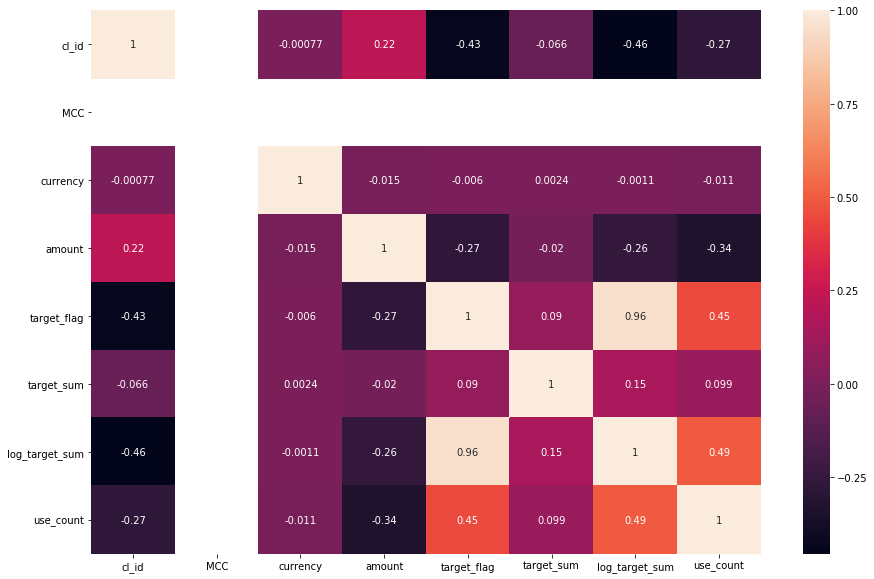

In [207]:
plt.figure(figsize=(15, 10))
sns.heatmap(train[train.trx_category == "WD_ATM_PARTNER"].corr(), annot=True)

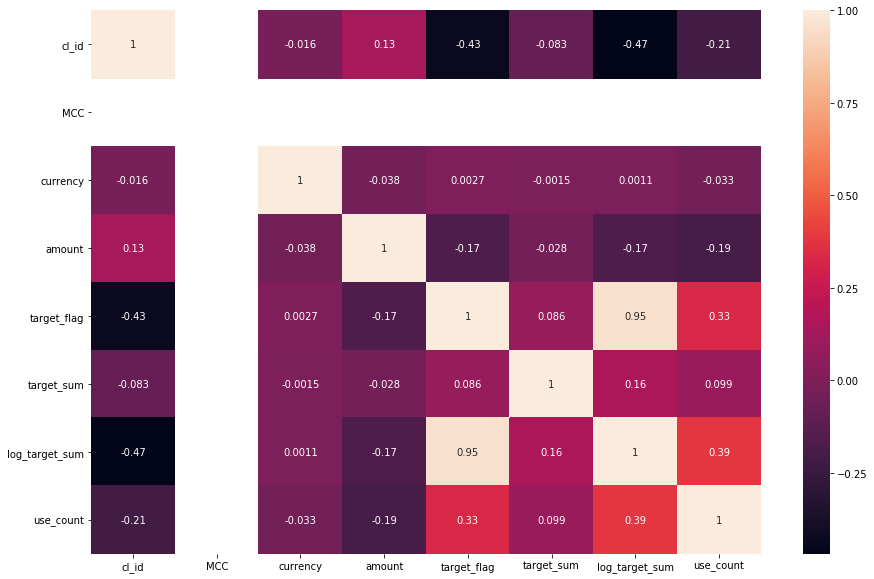

In [200]:
name = "WD_ATM_ROD"
tmp = train[train.trx_category == "WD_ATM_ROS"].groupby("cl_id")["amount"].agg(sum)
plt.figure(figsize=(15, 10))
sns.heatmap(train[train.trx_category == "WD_ATM_ROS"].groupby("cl_id")["amount"].agg(sum).corr(), annot=True)

In [202]:
train[train.trx_category == "WD_ATM_ROS"].shape

(19104, 12)

In [201]:
convTrain["amount"] = 

,cl_id,channel_type,target_flag,use_count,log_target_sum,useDay
0,0,NaN,0,1.791759,0.000000,53
1,1,NaN,0,4.653960,0.000000,92
2,5,NaN,1,4.962845,12.695305,92
3,9,NaN,0,3.688879,0.000000,89
4,10,NaN,0,6.139885,0.000000,89
5,11,NaN,0,5.384495,0.000000,91
6,14,NaN,1,4.919981,12.143014,92
7,20,NaN,0,4.356709,0.000000,73
8,21,NaN,0,4.828314,0.000000,88
9,22,NaN,0,4.094345,0.000000,66


In [209]:
train.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum', 'log_target_sum',
       'use_count'],
      dtype='object')

In [214]:
tmp = train.groupby("cl_id")["trx_category"].value_counts().unstack().fillna(0).reset_index(drop=True)

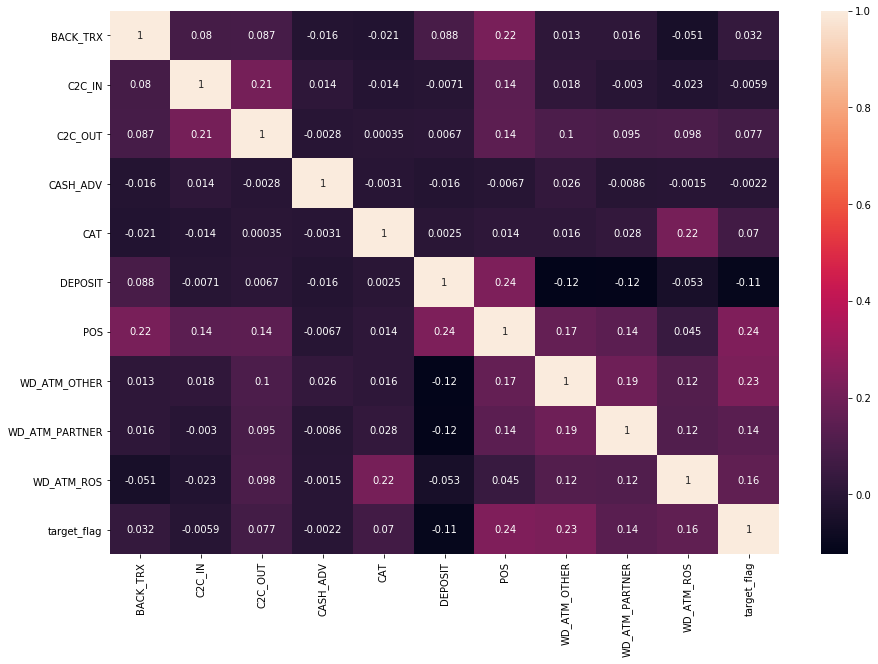

In [215]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.concat((tmp, convTrain.target_flag), axis=1).corr(), annot=True)

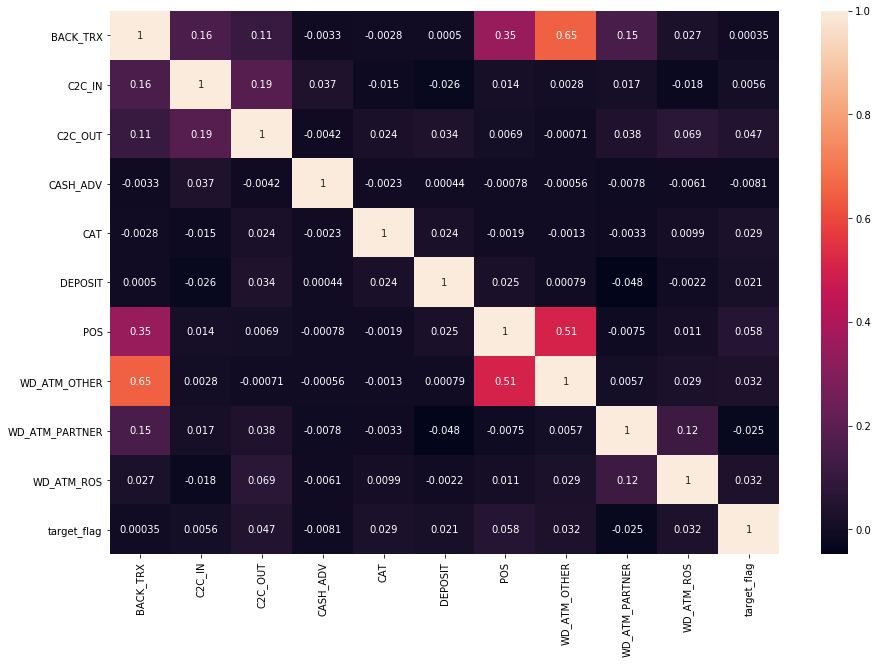

In [218]:
tmp = train.groupby(["cl_id", "trx_category"]).amount.agg(sum).unstack().fillna(0).reset_index(drop=True)
plt.figure(figsize=(15, 10))
sns.heatmap(pd.concat((tmp, convTrain.target_flag), axis=1).corr(), annot=True)

In [13]:
tmp = train.groupby("cl_id")["MCC"].value_counts().unstack().fillna(0).reset_index(drop=True)

In [23]:
names = pd.concat((tmp, convTrain.target_flag), axis=1).corr()["target_flag"].sort_values()[-20:].index[:-1]

In [24]:
print(names)

Index([7922, 7011, 9399, 5942, 5309, 5541, 5499, 5992, 5661, 5912, 5411, 4900,
       4814, 7230, 5999, 5691, 6011, 5812, 5814],
      dtype='object')


In [62]:
m = pd.concat((tmp[5814] + tmp[6011] + tmp[5999] + tmp[5912] + tmp[5691] + tmp[5812]), axis=1)
pd.concat((m, convTrain.target_flag), axis=1).corr()

,0,7230,target_flag
0,1.000000,0.293489,0.281884
7230,0.293489,1.000000,0.137216
target_flag,0.281884,0.137216,1.000000
